In [173]:
# libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

# Bagging, Randomforest

* bagging = bootstrap aggregating
* bootstrap: 복원추출
* 복원추출한 sample로 tree를 만들고, tree를 종합해 결과 산출
    * 회귀문제: tree 결과값 평균
    * 분류문제: 최빈값 선택
* 모델의 분산과 편향과 분산을 모두 줄일수 있다
* bagging
    * procedure
        1. 크기가 n 인 샘플 m개 추출(모든 column 사용)
        2. m개의 tree 구성
        3. m개의 tree aggregating
    * 모든 열을 사용하기 때문에 대부분의 tree 결과가 비슷할 수 있어 분산이 안작아짐
* randomforest
    * procedure
        1. 크기가 n 인 샘플 m개 추출(<span style='color:red'>일부 column 만 사용</span>)
        2. m개의 tree 구성
        3. m개의 tree aggregating
    * 일부 열만 사용해 tree를 구성, bagging의 단점을 보완할 수 있다.
    * 분류문제에서는 sqrt(m), 회귀문제에서는 m/3 개의 열 사용. tree 간 상관관계를 줄이고 분산도 줄일수있다.

In [105]:
root = 'C:/Users/wonca/Documents/git_repositories/TIL/2_머신러닝이론/4_tree_based_models/data/'
file_name = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'
hr_df = pd.read_csv(root + file_name)
print(hr_df.shape)
hr_df.head(2)

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7


## 변수선택

In [106]:
# ylabel
y = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_df['y'] = y

# 더미변수 생성
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
dummy_cols = []
for cat_col in categorical_cols:
    dummy_col = pd.get_dummies(hr_df[cat_col], prefix=cat_col)
    dummy_cols.append(dummy_col)

# 연속형 변수
origianl_numeric_cols = hr_df.select_dtypes(include=np.int64).columns.tolist()
remove_cols = ['EmployeeCount', 'EmployeeNumber', 'StandardHours']
numeric_cols = [el for el in origianl_numeric_cols if el not in remove_cols]
numeric_df = hr_df[numeric_cols]

# 더미변수 + 연속형변수
hr_new_df = pd.concat(dummy_cols + [numeric_df], axis=1)

# train test splitㅠ
x = hr_new_df.drop(['y'], axis=1)
y = hr_new_df['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.7, random_state=42)

## Decision Tree, Bagging, Randomfrest 비교

In [152]:
# dt
# 분기기준: 지니불순도
# 최대깊이: 5
# 분할을 위한 최소관측값: 2개
# leaf node 최소관측값: 1개
class_weight = {0: .2, 1: .8}

dt_model = DecisionTreeClassifier(criterion='gini',
                                  max_depth=5, 
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  random_state=42,
                                  class_weight=class_weight
                                  )

# 5000개 샘플, 각 샘플은 전체 데이터의 2/3
bagging_model = BaggingClassifier(base_estimator=dt_model,
                                  n_estimators=5000,
                                  max_features=0.67,
                                  bootstrap=True,
                                  bootstrap_features=False,
                                  n_jobs=-1, random_state=42,
                                  )

rf_model = RandomForestClassifier(n_estimators=5000,
                                  criterion='gini',
                                  max_depth=5,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  bootstrap=True,
                                  max_features='auto',
                                  random_state=42, n_jobs=-1,
                                  class_weight=class_weight
                                  )

dt_model.fit(x_train, y_train)
bagging_model.fit(x_train, y_train)
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.2, 1: 0.8},
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5000, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [153]:
def confusion_matrix(y_true, y_pred):
    return pd.crosstab(y_trun, y_pred, colnames=['Predicted'], rownames=['Actual'])

In [154]:
# train, test- acc, 1_recl, 1_prec, 0_recl, 0_pred
result_table = np.empty((3, 10))
result_table = pd.DataFrame(result_table)
result_table.columns = ['train_acc', 'train_1_recl', 'train_1_prec', 'train_0_recl', 'train_0_prec', 'test_acc', 'test_1_recl', 'test_1_prec', 'test_0_recl', 'test_0_prec']

In [155]:
# results
y_insamp_pred_dt = dt_model.predict(x_train)
y_outsamp_pred_dt = dt_model.predict(x_test)
y_insamp_pred_bagging = bagging_model.predict(x_train)
y_outsamp_pred_bagging = bagging_model.predict(x_test)
y_insamp_pred_rf = rf_model.predict(x_train)
y_outsamp_pred_rf = rf_model.predict(x_test)

y_insamp_pred = [y_insamp_pred_dt, y_insamp_pred_bagging, y_insamp_pred_rf]
y_outsamp_pred = [y_outsamp_pred_dt, y_outsamp_pred_bagging, y_outsamp_pred_rf]
for i in range(3):
    clf_report_train = classification_report(y_train, y_insamp_pred[i], output_dict=True)
    clf_report_test = classification_report(y_test, y_outsamp_pred[i], output_dict=True)

    result_table.loc[i, 'train_acc'] = clf_report_train['accuracy']
    result_table.loc[i, 'train_1_recl'] = clf_report_train['1']['recall']
    result_table.loc[i, 'train_1_prec'] = clf_report_train['1']['precision']
    result_table.loc[i, 'train_0_recl'] = clf_report_train['0']['recall']
    result_table.loc[i, 'train_0_prec'] = clf_report_train['0']['precision']
    
    result_table.loc[i, 'test_acc'] = clf_report_test['accuracy']
    result_table.loc[i, 'test_1_recl'] = clf_report_test['1']['recall']
    result_table.loc[i, 'test_1_prec'] = clf_report_test['1']['precision']
    result_table.loc[i, 'test_0_recl'] = clf_report_test['0']['recall']
    result_table.loc[i, 'test_0_prec'] = clf_report_test['0']['precision']

In [156]:
result_table.index = ['dt', 'bagging', 'rf']

In [157]:
result_table

,train_acc,train_1_recl,train_1_prec,train_0_recl,train_0_prec,test_acc,test_1_recl,test_1_prec,test_0_recl,test_0_prec
dt,0.891156,0.868421,0.634615,0.895890,0.970326,0.752187,0.372671,0.280374,0.822581,0.876074
bagging,0.986395,0.934211,0.986111,0.997260,0.986450,0.865889,0.254658,0.694915,0.979263,0.876289
rf,0.975057,0.894737,0.957746,0.991781,0.978378,0.867833,0.260870,0.711864,0.980415,0.877320


In [166]:
# 지니 평균값 감소를 기준으로 산출한 변수중요도
model_ranks = pd.Series(rf_model.feature_importances_, index=x_train.columns, name='Importance').sort_values(ascending=False)
top_features = model_ranks.iloc[:31].sort_values(ascending=True, inplace=False)

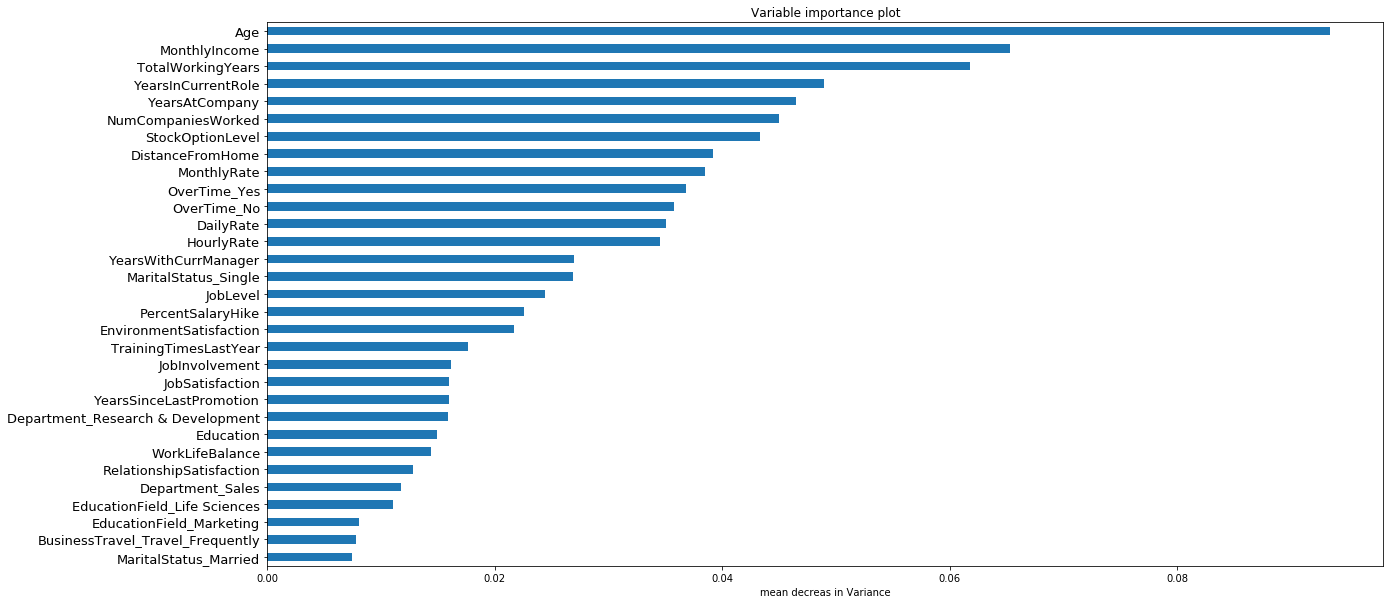

In [169]:
plt.figure(figsize=[20, 10])
ax = top_features.plot(kind='barh')
ax.set_title('Variable importance plot')
ax.set_xlabel('mean decreas in Variance')
ax.set_yticklabels(top_features.index, fontsize=13)
plt.show()

## 랜덤포레스트 튜닝

In [176]:
class_weight = {0: .2, 1: .8}
rf_model = RandomForestClassifier(n_estimators=5000,
                                  criterion='gini',
                                  max_depth=5,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  bootstrap=True,
                                  max_features='auto',
                                  random_state=42, n_jobs=-1,
                                  class_weight=class_weight
                                  )

pipeline = Pipeline([
    ('clf', rf_model)
])

parameters = {
    'clf__n_estimators': [2000, 3000, 5000, 7000],
    'clf__max_depth': [5, 15, 30],
    'clf__min_samples_split': [2, 3],
    'clf__min_samples_leaf': [1, 2]}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, verbose=1, scoring='roc_auc')
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 11.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight={0: 0.2,
                                                                             1: 0.8},
                                                               criterion='gini',
                                                               max_depth=5,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                    

In [178]:
grid_search.best_score_

0.7729222967725904

In [179]:
grid_search.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight={0: 0.2,
                                                                             1: 0.8},
                                                               criterion='gini',
                                                               max_depth=5,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                             

In [184]:
y_pred = grid_search.best_estimator_.predict(x_test)

In [189]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       868
           1       0.83      0.12      0.22       161

    accuracy                           0.86      1029
   macro avg       0.85      0.56      0.57      1029
weighted avg       0.86      0.86      0.81      1029

